# Loading the Spikes
This notebook shows all the different ways how you can load spikes from the recording and some first analysis steps

In [33]:
import sys
sys.path.extend(['/home/mawa/PycharmProjects/polarspike'])
from IPython.display import display, HTML
from polarspike import Overview, recording_overview, spiketrain_plots, colour_template
import polars as pl
from bokeh.io import output_notebook
from bokeh.plotting import show
import matplotlib.pyplot as plt
output_notebook()
# If you want interactive plots:
%matplotlib widget

Loading BokehJS ...

# The general structure.
The idea behind the organization of spikes in Polarspike is that spikes are saved on the NAS disk (or other disk) in a polars dataframe and only a subset of spikes necessary for the analysis is loaded into memory.
The spikes are saved in a file called "spike_times.parquet" in the recording folder. Lets have a look at a example recording. This recording is stored on the NAS in "/home/mawa/nas_a/Marvin/chicken_09_05_2024/kilosort4". The spikes are saved in the same folder, we could access them using polars directly.


In [2]:
spikes_on_disk = pl.scan_parquet(r"/home/mawa/nas_a/Marvin/chicken_09_05_2024/kilosort4/spike_times.parquet")
spikes_on_disk

The pl.scan_parquet method allows to check the data <b>without</b> loading it into memory. This is very useful to check if the data is present and to check the columns. If we had loaded the whole table into memory, and this was a huge dataframe, we might run into memory issues already. It is possible to access some of the information without loading everything into memory:

In [3]:
spikes_on_disk.collect_schema().names()

['cell_index', 'times']

As we can see above, the dataframe contains the columns "cell_index" and "times". The cell_index colum indicates the cell_index and the times column the frame at which a spike was recorded. Lets look at the first 5 rows. In polars, we can use the collect method to load a subset of data into memory, without loading the whole dataframe. 

In [4]:
spikes_on_disk.head(5).collect()

shape: (5, 2)
┌────────────┬───────┐
│ cell_index ┆ times │
│ ---        ┆ ---   │
│ i64        ┆ i64   │
╞════════════╪═══════╡
│ 541        ┆ 6003  │
│ 381        ┆ 6005  │
│ 86         ┆ 6012  │
│ 487        ┆ 6013  │
│ 547        ┆ 6016  │
└────────────┴───────┘

As you can see, the spikes are stored sorted by time but not by cell_index. To get all spikes for a given cell we would have to filter the dataframe accordingly. No worries, this is all made easy by Polarspike's functions

At this stage, we can feed the dataframe into recording_overview plots to get a quick overview of the spikes. The plotting is done by streaming the data from the disk, so at no time do we require to load the whole dataframe into memory. Since the spikes on the disk are saved in frames, rather than seconds, we need to provide the sampling frequency of the recording, which we need to know.

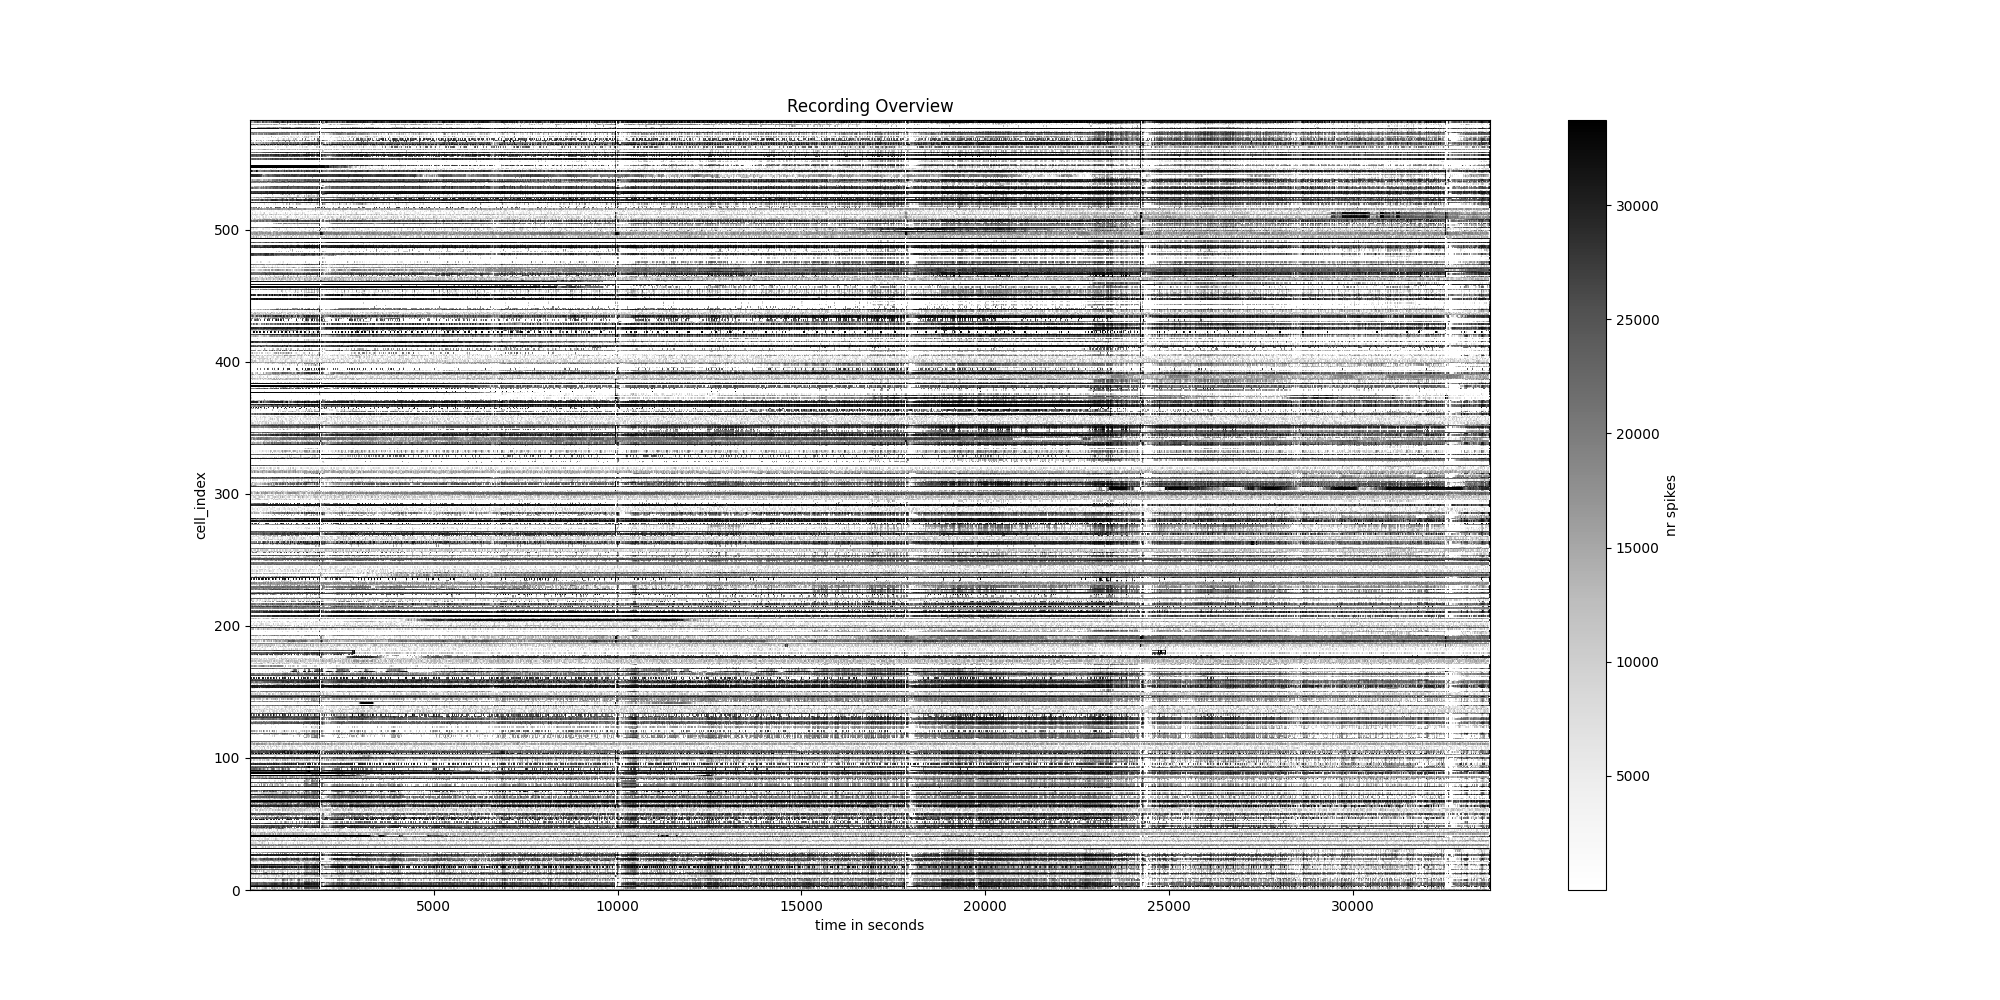

In [5]:
fig, ax = recording_overview.spiketrains_from_file(
    r"/home/mawa/nas_a/Marvin/chicken_09_05_2024/kilosort4/spike_times.parquet",
    freq=20000, backend="matplotlib")

This figure should look familiar to you from the user GUI. It simply reads all spikes from the dataframe and represents the combined spiketrains of all cells as heatmap. The  If you used the magic matplotlib command %matplotlib widget. This figure will be interactive. The cool thing about this is that now you can zoom into the figure. Each time you zoom, the spikes become binned newly, and thus you see more and more details. We dont use these figures for specific analysis, but they are very useful after a recording to get a "feeling" for what happened. For example, did the spikerate of the whole tissue increase or decrease at some point? Anything unusual?

# Recording object
In most cases, we will have used the GUI to create an "overview" file in the recording folder. We can access the parquet file (the spikes in the dataframe on disk) directly from the recording object:

In [6]:
recording = Overview.Recording.load(r"/home/mawa/nas_a/Marvin/chicken_09_05_2024/kilosort4/overview")
recording.parquet_path

PosixPath('/home/mawa/nas_a/Marvin/chicken_09_05_2024/kilosort4/spike_times.parquet')

So the graph we created above can be created more easily by using the recording object. This also allows us to access the sampling frequency of the recording.

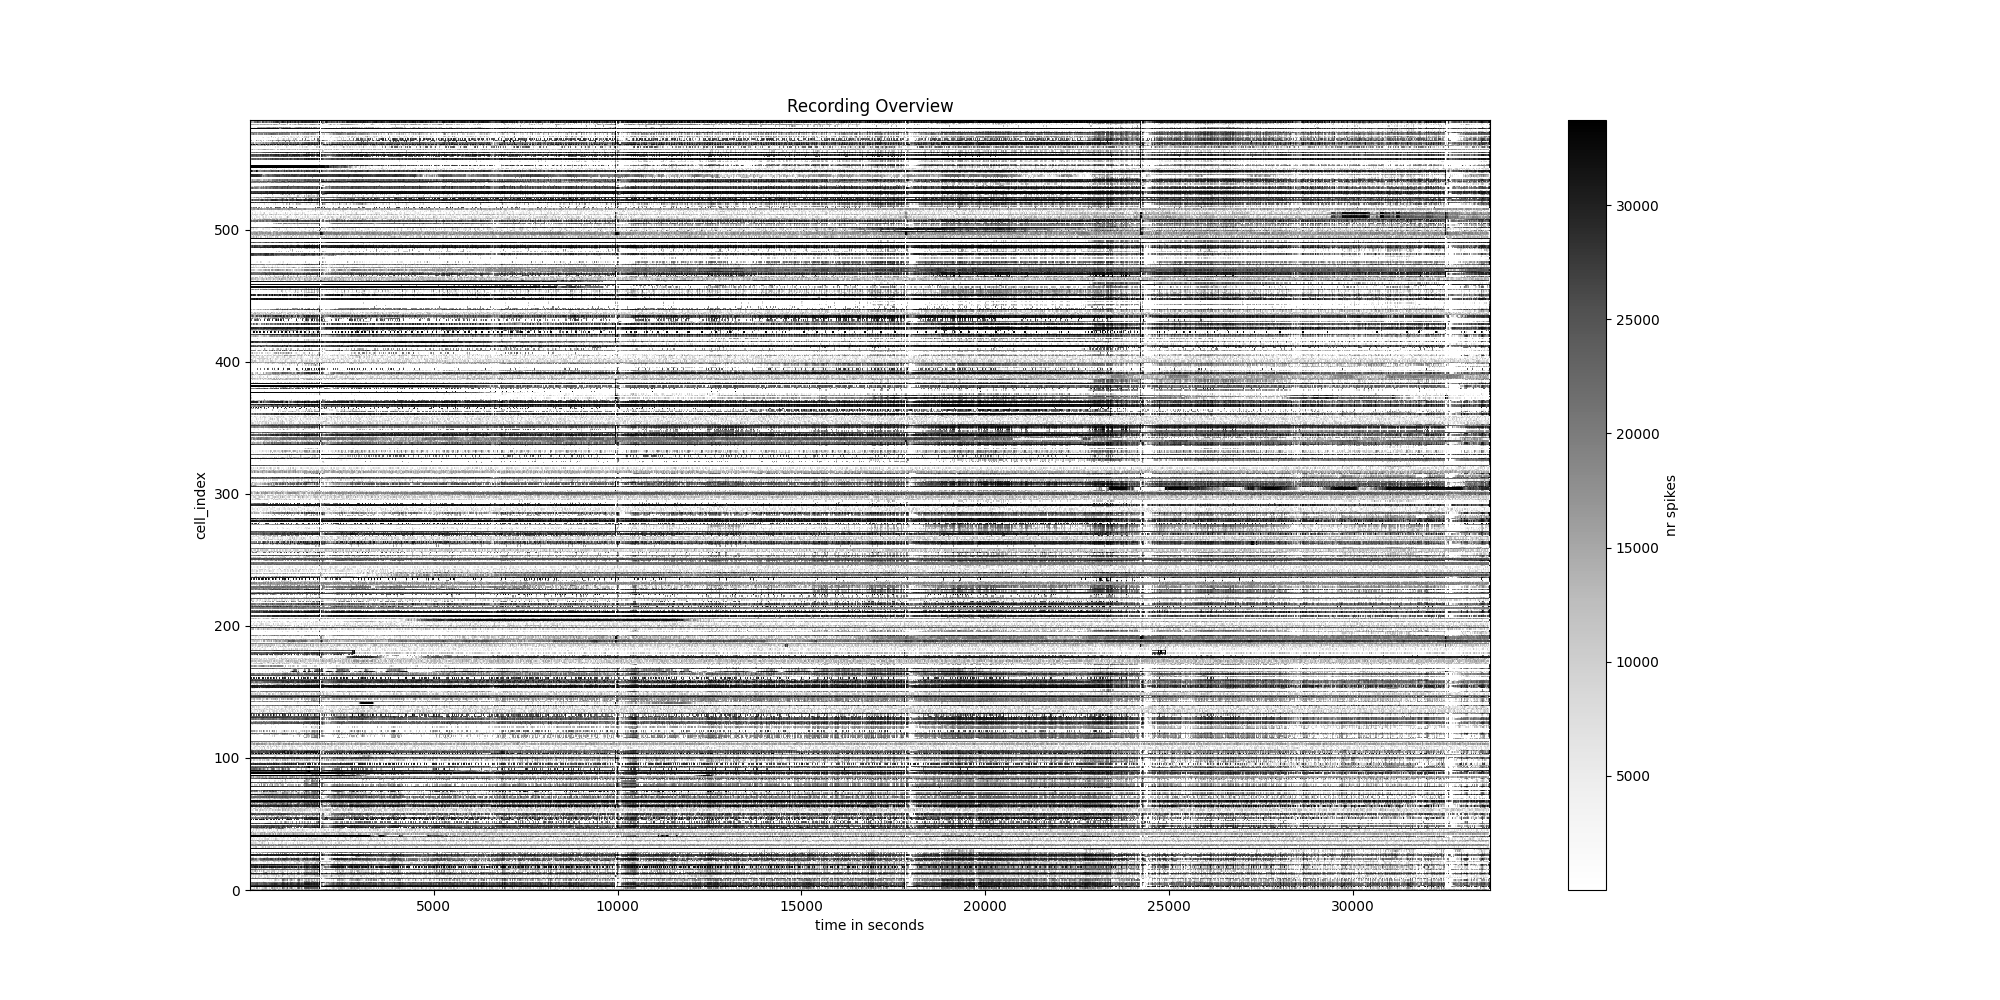

In [7]:
fig, ax = recording_overview.spiketrains_from_file(recording.parquet_path, freq=recording.sampling_freq,
                                                   backend="matplotlib")

## Recording object structure
The recording object stores all the data of a recording and makes it easy to access spikes.

In [8]:
display(HTML(
    f"recording_name: {recording.name},<br> recording_path: {recording.raw_path}<br> number of cells: {recording.nr_cells}<br> number of stimuli: {recording.nr_stimuli}<br> "
    f"sampling frequency: {recording.sampling_freq}"))

Most important are the data stored in the two main dataframes in the recording object: spikes_df and stimulus_df. Spikes_df stores information about how often each cell spiked during a specific stimulus, and its position on the MEA. It can also store much more information, like the quality of a cell's response etc. This dataframe can grow over time when more and more aspects are analysed.

In [9]:
recording.spikes_df

cell_index  stimulus_index            stimulus_name  nr_of_spikes  \
0               0               0                 fff_1_nd           230   
1               0               1                 fff_1_nd           235   
2               0               2                 fff_1_nd           248   
3               0               3                 fff_1_nd           262   
4               0               4                fff_02_nd           243   
...           ...             ...                      ...           ...   
11675         583              15  12px_20Hz_shuffle_white         69965   
11676         583              16   2px_30Hz_shuffle_white        121810   
11677         583              17                 fff_1_nd          2047   
11678         583              18                 fff_2_nd          1991   
11679         583              19                fff_02_nd          3466   

         centres_x    centres_y              recording  qi  
0         0.000000   100.000000  chicken_09_05_2024_p0 NaN  
1         0.000000   100.000000  chicken_09_05_2024_p0 NaN  
2         0.000000   100.000000  chicken_09_05_2024_p0 NaN  
3         0.000000   100.000000  chicken_09_05_2024_p0 NaN  
4         0.000000   100.000000  chicken_09_05_2024_p0 NaN  
...            ...          ...                    ...  ..  
11675  1488.341309  1406.954102  chicken_09_05_2024_p0 NaN  
11676  1488.341309  1406.954102  chicken_09_05_2024_p0 NaN  
11677  1488.341309  1406.954102  chicken_09_05_2024_p0 NaN  
11678  1488.341309  1406.954102  chicken_09_05_2024_p0 NaN  
11679  1488.341309  1406.954102  chicken_09_05_2024_p0 NaN  

[11680 rows x 8 columns]

The second important dataframe, stimulus_df, stores the information about the played stimuli. It stores the trigger times, how often a stimulus was repeated etc.

In [10]:
recording.stimulus_df

stimulus_name   begin_fr     end_fr  \
0                  fff_1_nd     582766    3782714   
1                  fff_1_nd    4522709    7722658   
2                  fff_1_nd    8542713   11742661   
3                  fff_1_nd   12202661   15402610   
4                 fff_02_nd   17643185   20843133   
5                 fff_02_nd   21203134   24403084   
6                       fff   25623072   28823021   
7               moving_bars   29247221   37247950   
8                   fff_top   40911230   45713579   
9                   fff_top   46833565   51635917   
10   4px_20Hz_shuffle_610nm   54226065  198223556   
11              moving_bars  201854769  209855516   
12   4px_20Hz_shuffle_535nm  211593473  355591078   
13          moving_bar_tiny  358982390  374986078   
14                   cnoise  375739058  393738925   
15  12px_20Hz_shuffle_white  395757981  467757212   
16   2px_30Hz_shuffle_white  499547287  649544714   
17                 fff_1_nd  659475935  662675886   
18                 fff_2_nd  664524964  667724916   
19                fff_02_nd  668792660  671992617   

                                  trigger_fr_relative  \
0   [0, 79992, 159991, 239990, 319989, 399988, 479...   
1   [0, 79993, 159992, 239991, 319989, 399988, 479...   
2   [0, 79992, 159991, 239990, 319989, 399988, 479...   
3   [0, 79992, 159991, 239990, 319989, 399988, 479...   
4   [0, 79992, 159991, 239990, 319989, 399987, 479...   
5   [0, 79993, 159992, 239990, 319989, 399988, 479...   
6   [0, 79993, 159992, 239990, 319989, 399988, 479...   
7   [0, 337, 669, 1004, 1358, 1694, 2027, 2361, 26...   
8   [0, 80038, 160077, 240116, 320155, 400194, 480...   
9   [0, 80040, 160079, 240119, 320158, 400197, 480...   
10  [0, 975, 1979, 2979, 3979, 4979, 5979, 6977, 7...   
11  [0, 332, 665, 998, 1331, 1665, 1998, 2331, 266...   
12  [0, 994, 1994, 2994, 3995, 4993, 5993, 6993, 8...   
13  [0, 338, 669, 1004, 1335, 1671, 2002, 2336, 26...   
14  [0, 662, 1328, 1995, 2662, 3328, 3995, 4662, 5...   
15  [0, 1000, 2000, 3000, 4000, 5001, 6001, 7001, ...   
16  [0, 585, 1237, 1904, 2571, 3235, 3904, 4568, 5...   
17  [0, 79993, 159992, 239991, 319990, 399988, 479...   
18  [0, 79994, 159993, 239992, 319991, 399990, 479...   
19  [0, 79999, 159998, 239997, 319996, 399995, 479...   

                                          trigger_int  stimulus_index  \
0   [79992, 79999, 79999, 79999, 79999, 79998, 799...               0   
1   [79993, 79999, 79999, 79998, 79999, 79999, 799...               1   
2   [79992, 79999, 79999, 79999, 79999, 79998, 799...               2   
3   [79992, 79999, 79999, 79999, 79999, 79999, 799...               3   
4   [79992, 79999, 79999, 79999, 79998, 79999, 799...               4   
5   [79993, 79999, 79998, 79999, 79999, 79999, 799...               5   
6   [79993, 79999, 79998, 79999, 79999, 79999, 799...               6   
7   [337, 332, 335, 354, 336, 333, 334, 333, 333, ...               7   
8   [80038, 80039, 80039, 80039, 80039, 80040, 800...               8   
9   [80040, 80039, 80040, 80039, 80039, 80039, 800...               9   
10  [975, 1004, 1000, 1000, 1000, 1000, 998, 1000,...              10   
11  [332, 333, 333, 333, 334, 333, 333, 334, 333, ...              11   
12  [994, 1000, 1000, 1001, 998, 1000, 1000, 1008,...              12   
13  [338, 331, 335, 331, 336, 331, 334, 333, 333, ...              13   
14  [662, 666, 667, 667, 666, 667, 667, 666, 667, ...              14   
15  [1000, 1000, 1000, 1000, 1001, 1000, 1000, 998...              15   
16  [585, 652, 667, 667, 664, 669, 664, 669, 668, ...              16   
17  [79993, 79999, 79999, 79999, 79998, 79999, 799...              17   
18  [79994, 79999, 79999, 79999, 79999, 79998, 800...              18   
19  [79999, 79999, 79999, 79999, 79999, 79999, 799...              19   

    stimulus_repeat_logic  stimulus_repeat_sublogic  sampling_freq  \
0                       8                         2        20000.0   
1                       8   

To reiterate: These dataframes <b> dont </b> store any spiketimes in them. But they store the information necessary to meaningfully get the spikes from the dataframe mentioned about stored on the NAS/ disk.

## Loading subsets of spikes
In most cases, we want to analyse only a subset of spikes. For example, we might only be interested in the spikes that were recorded
during a specific stimulus presentation for this analysis. In this case, we can load only the spikes that are relevant for the analysis using methods of the recording object.
In those cases, the recording object will scan the .parquet file, search for the spikes that fall within the time of the stimulus presentation and load only those spikes into memory.

The most straightforward and most explicit way to load the spikes is to use the "get_spikes_triggered" function, which I will explain in some detail:
```python
def get_spikes_triggered(
            self,
            filter_conditions: list[dict],
            time: str = "seconds",
            waveforms: bool = False,
            pandas: bool = True,
            cell_df: str = "spikes_df",
            stimulus_df: str = "stimulus_df",
            carry: list[str] = None,
    ) -> pd.DataFrame | pl.DataFrame:

```
We can define filter conditions in a list of dictionaries, we can decide if we want the time in "seconds" or "frames". In theory we can load the waveforms (but this option only works for recordings spikesorted with HerdingSpikes2 and is currently not implemented anymore), we can get the returned dataframe either as Pandas or Polars dataframe. I will explain the further input parameters below.

In [11]:
# Load one stimulus and one cell
recording.get_spikes_triggered([{"cell_index": 10, "stimulus_index": 0}])

cell_index      times  stimulus_index              recording  \
0           10   36.02210               0  chicken_09_05_2024_p0   
1           10   42.81985               0  chicken_09_05_2024_p0   
2           10   43.86715               0  chicken_09_05_2024_p0   
3           10   44.35785               0  chicken_09_05_2024_p0   
4           10   49.87895               0  chicken_09_05_2024_p0   
..         ...        ...             ...                    ...   
62          10  182.86610               0  chicken_09_05_2024_p0   
63          10  185.19385               0  chicken_09_05_2024_p0   
64          10  186.15050               0  chicken_09_05_2024_p0   
65          10  186.76685               0  chicken_09_05_2024_p0   
66          10  187.45125               0  chicken_09_05_2024_p0   

    times_relative  trigger  repeat  times_triggered  
0          6.88380        1       0          6.88380  
1         13.68155        3       0         13.68155  
2         14.72885        3       0         14.72885  
3         15.21955        3       0         15.21955  
4         20.74065        5       0         20.74065  
..             ...      ...     ...              ...  
62       153.72780        6       4         25.72995  
63       156.05555        7       4         28.05770  
64       157.01220        7       4         29.01435  
65       157.62855        7       4         29.63070  
66       158.31295        7       4         30.31510  

[67 rows x 8 columns]

In [12]:
# Load one stimulus and two cells:
recording.get_spikes_triggered([{"cell_index": [5, 10], "stimulus_index": 0}])

cell_index      times  stimulus_index              recording  \
0             5   29.16330               0  chicken_09_05_2024_p0   
1             5   29.22145               0  chicken_09_05_2024_p0   
2             5   29.64175               0  chicken_09_05_2024_p0   
3             5   29.94445               0  chicken_09_05_2024_p0   
4             5   29.95430               0  chicken_09_05_2024_p0   
..          ...        ...             ...                    ...   
709          10  182.86610               0  chicken_09_05_2024_p0   
710          10  185.19385               0  chicken_09_05_2024_p0   
711          10  186.15050               0  chicken_09_05_2024_p0   
712          10  186.76685               0  chicken_09_05_2024_p0   
713          10  187.45125               0  chicken_09_05_2024_p0   

     times_relative  trigger  repeat  times_triggered  
0           0.02500        0       0          0.02500  
1           0.08315        0       0          0.08315  
2           0.50345        0       0          0.50345  
3           0.80615        0       0          0.80615  
4           0.81600        0       0          0.81600  
..              ...      ...     ...              ...  
709       153.72780        6       4         25.72995  
710       156.05555        7       4         28.05770  
711       157.01220        7       4         29.01435  
712       157.62855        7       4         29.63070  
713       158.31295        7       4         30.31510  

[714 rows x 8 columns]

In [13]:
# Load two stimuli and two cells:
recording.get_spikes_triggered([{"cell_index": [5, 10], "stimulus_index": [0, 1]}])

cell_index      times  stimulus_index              recording  \
0              5   29.16330               0  chicken_09_05_2024_p0   
1              5   29.22145               0  chicken_09_05_2024_p0   
2              5   29.64175               0  chicken_09_05_2024_p0   
3              5   29.94445               0  chicken_09_05_2024_p0   
4              5   29.95430               0  chicken_09_05_2024_p0   
...          ...        ...             ...                    ...   
1360          10  377.85175               1  chicken_09_05_2024_p0   
1361          10  378.25230               1  chicken_09_05_2024_p0   
1362          10  379.37270               1  chicken_09_05_2024_p0   
1363          10  379.90355               1  chicken_09_05_2024_p0   
1364          10  384.15245               1  chicken_09_05_2024_p0   

      times_relative  trigger  repeat  times_triggered  
0            0.02500        0       0          0.02500  
1            0.08315        0       0          0.08315  
2            0.50345        0       0          0.50345  
3            0.80615        0       0          0.80615  
4            0.81600        0       0          0.81600  
...              ...      ...     ...              ...  
1360       151.71630        5       4         23.71840  
1361       152.11685        6       4         24.11895  
1362       153.23725        6       4         25.23935  
1363       153.76810        6       4         25.77020  
1364       158.01700        7       4         30.01910  

[1365 rows x 8 columns]

In [14]:
# Load all cells from a stimulus
spikes = recording.get_spikes_triggered([{"stimulus_index": 0}])
spikes

cell_index      times  stimulus_index              recording  \
0                0   30.01905               0  chicken_09_05_2024_p0   
1                0   31.70680               0  chicken_09_05_2024_p0   
2                0   32.69225               0  chicken_09_05_2024_p0   
3                0   33.33605               0  chicken_09_05_2024_p0   
4                0   33.99035               0  chicken_09_05_2024_p0   
...            ...        ...             ...                    ...   
356417         583  189.03295               0  chicken_09_05_2024_p0   
356418         583  189.04370               0  chicken_09_05_2024_p0   
356419         583  189.05400               0  chicken_09_05_2024_p0   
356420         583  189.06765               0  chicken_09_05_2024_p0   
356421         583  189.11255               0  chicken_09_05_2024_p0   

        times_relative  trigger  repeat  times_triggered  
0              0.88075        0       0          0.88075  
1              2.56850        0       0          2.56850  
2              3.55395        0       0          3.55395  
3              4.19775        1       0          4.19775  
4              4.85205        1       0          4.85205  
...                ...      ...     ...              ...  
356417       159.89465        7       4         31.89680  
356418       159.90540        7       4         31.90755  
356419       159.91570        7       4         31.91785  
356420       159.92935        7       4         31.93150  
356421       159.97425        7       4         31.97640  

[356422 rows x 8 columns]

To quickly explain what happens under the hood: When we load cell 0 and stimulus 0 the function will look at the stimulus_df in the recording object and find the information about when stimulus 0 was played (begin_fr to end_fr). It will access the .parquet file and scan it for spikes falling in that time window. It will then check between which triggers each spike falls and sort accordingly. Lets have a closer look at the returned dataframe:

In [15]:
spikes

cell_index      times  stimulus_index              recording  \
0                0   30.01905               0  chicken_09_05_2024_p0   
1                0   31.70680               0  chicken_09_05_2024_p0   
2                0   32.69225               0  chicken_09_05_2024_p0   
3                0   33.33605               0  chicken_09_05_2024_p0   
4                0   33.99035               0  chicken_09_05_2024_p0   
...            ...        ...             ...                    ...   
356417         583  189.03295               0  chicken_09_05_2024_p0   
356418         583  189.04370               0  chicken_09_05_2024_p0   
356419         583  189.05400               0  chicken_09_05_2024_p0   
356420         583  189.06765               0  chicken_09_05_2024_p0   
356421         583  189.11255               0  chicken_09_05_2024_p0   

        times_relative  trigger  repeat  times_triggered  
0              0.88075        0       0          0.88075  
1              2.56850        0       0          2.56850  
2              3.55395        0       0          3.55395  
3              4.19775        1       0          4.19775  
4              4.85205        1       0          4.85205  
...                ...      ...     ...              ...  
356417       159.89465        7       4         31.89680  
356418       159.90540        7       4         31.90755  
356419       159.91570        7       4         31.91785  
356420       159.92935        7       4         31.93150  
356421       159.97425        7       4         31.97640  

[356422 rows x 8 columns]

Each row in this dataframe represents a spike. The first column, "cell_index" indicates which cell this spikes belongs to. The column "times" just shows the times linearly as recorded in the recording. If the stimulus was presented after 1 hour after starting the recording, than the minimum value here would be 1h. times_relative stores the times relative to the stimulus begin, the column "trigger" indicates after which trigger within a stimulus the spike was recorded. Since stimuli are often repeated several times, repeat indicates in which repeat the spike was recorded. Finally, times_triggered shows the spike times relative relative to the beginning of a stimulus repeat.

# Warning!
Be aware that cells which dont spike at all during a stimulus presentation will not appear in the output. This is because the function only loads the spikes that are present in the dataframe.
You can use the cells variable to check which cells are present in the output.

In [16]:
spikes["cell_index"].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 116, 117, 118, 119, 120, 123, 125, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       169, 171, 172, 173, 174, 175, 176, 177, 178, 179, 181, 182, 183,
       184, 185, 186, 187, 188, 189, 190, 191, 192, 195, 197, 19

### Analysis
Ok, we loaded all the spikes, but what to do with it?, First we could plot them. Lets plot for a single cell first. We can do this by using the spiketrain_plots module

In [17]:
spikes = recording.get_spikes_triggered([{"stimulus_index": 6, "cell_index": 5}])

In [18]:
fig = spiketrain_plots.spikes_and_trace(spikes, ["stimulus_index", "repeat"])
show(fig)

great, so we plotted the spikes aligned by the stimulus_index and by repeats. But it would be better if we knew what we actually presented. We can use the colour template to add full field colours to this particular stimulus

In [19]:
ct = colour_template.Colour_template()
ct.pick_stimulus("FFF_8_MC")

<span style="font-family: monospace">#fd1717 <span style="color: #fd1717">████</span></span> <span style="font-family: monospace">#000000 <span style="color: #000000">████</span></span> <span style="font-family: monospace">#fe7c7c <span style="color: #fe7c7c">████</span></span> <span style="font-family: monospace">#000000 <span style="color: #000000">████</span></span> <span style="font-family: monospace">#fafe7c <span style="color: #fafe7c">████</span></span> <span style="font-family: monospace">#000000 <span style="color: #000000">████</span></span> <span style="font-family: monospace">#dffc7e <span style="color: #dffc7e">████</span></span> <span style="font-family: monospace">#000000 <span style="color: #000000">████</span></span> <span style="font-family: monospace">#8afe7c <span style="color: #8afe7c">████</span></span> <span style="font-family: monospace">#000000 <span style="color: #000000">████</span></span> <span style="font-family: monospace">#7cfcfe <span style="color: #7cfcfe">████</span></span> <span style="font-family: monospace">#000000 <span style="color: #000000">████</span></span> <span style="font-family: monospace">#7c86fe <span style="color: #7c86fe">████</span></span> <span style="font-family: monospace">#000000 <span style="color: #000000">████</span></span> <span style="font-family: monospace">#fe7cfe <span style="color: #fe7cfe">████</span></span> <span style="font-family: monospace">#000000 <span style="color: #000000">████</span></span>

In [20]:
fig = ct.add_stimulus_to_plot(fig, [2] * 16)
show(fig)

Here, we have loaded the flash template for the stimulus FFF_8_MC and plotted it with each flash lasting 2 seconds and 16 flashes in total

Since we know how to load spikes, we can do the same thing with multiple cells:

In [21]:
spikes = recording.get_spikes_triggered([{"stimulus_index": 6, "cell_index": [5, 6, 7]}])

In [22]:
fig = spiketrain_plots.spikes_and_trace(spikes, ["stimulus_index", "repeat"])
fig = ct.add_stimulus_to_plot(fig, [2] * 16)
show(fig)

Great, but we haven't aligned the spikes based on cell_index, let's do that:

In [23]:
fig = spiketrain_plots.spikes_and_trace(spikes, ["cell_index", "repeat"])
fig = ct.add_stimulus_to_plot(fig, [2] * 16)
show(fig)

Nice, but all cells share the spike rate on top, lets give each cell a unique color and trace:

In [24]:
fig = spiketrain_plots.spikes_and_trace(spikes, ["cell_index", "repeat"], line_colour=["black", "green", "red"],
                                        single_psth=False)
fig = ct.add_stimulus_to_plot(fig, [2] * 16)
show(fig)

Ok, great, but if we plot more and more cells, the figure will become more and more busy. For those situations there is a heatmap plot which is better fit

In [25]:
# load all cells
spikes = recording.get_spikes_triggered([{"stimulus_index": 6}])

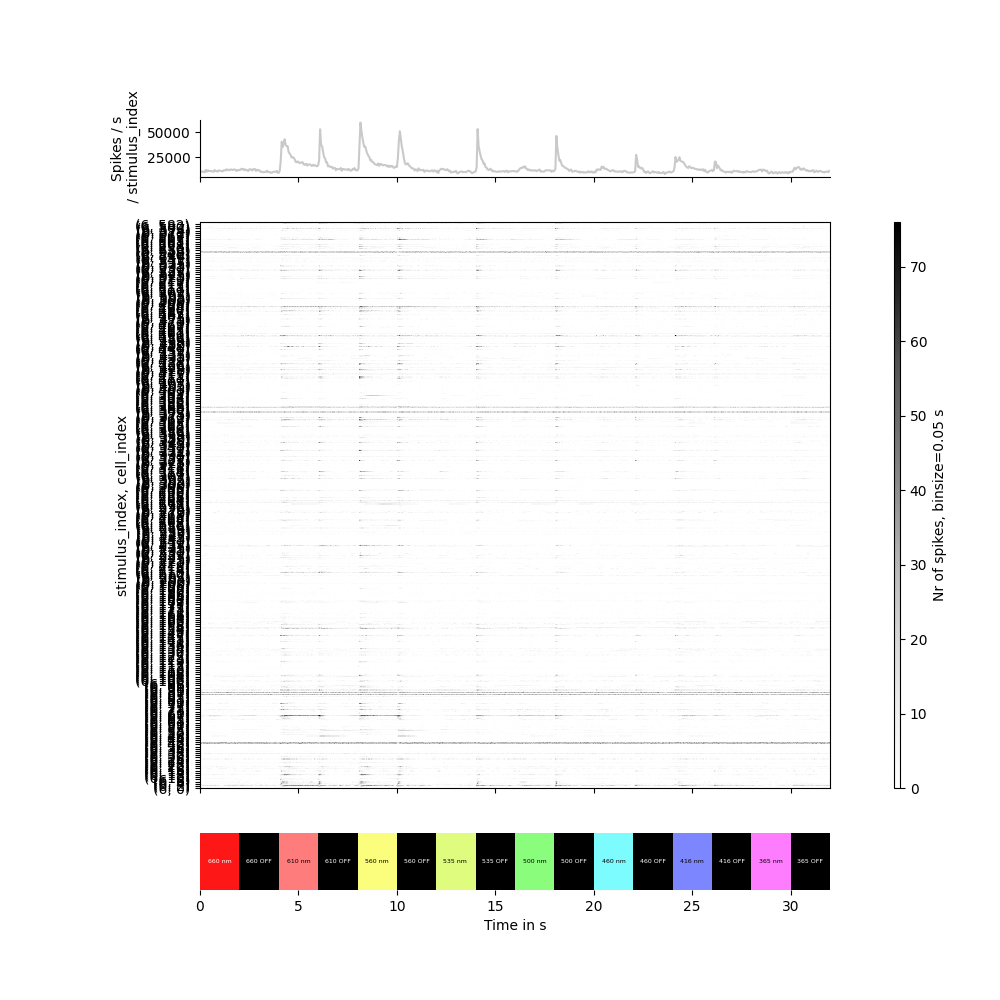

In [26]:
fig, ax = spiketrain_plots.whole_stimulus(spikes, indices=["stimulus_index", "cell_index"])
fig = ct.add_stimulus_to_plot(fig, [2] * 16)

As you can see, this recreates an interactive heatmap figure as show at the very beginning, this time for a single stimulus only and with the flashes plotted below. It is interactive if you run the matplotlib magic command

We can also compare two stimuli, here fff and fff with nd filter:

In [27]:
spikes = recording.get_spikes_triggered([{"stimulus_index": [5, 6]}])

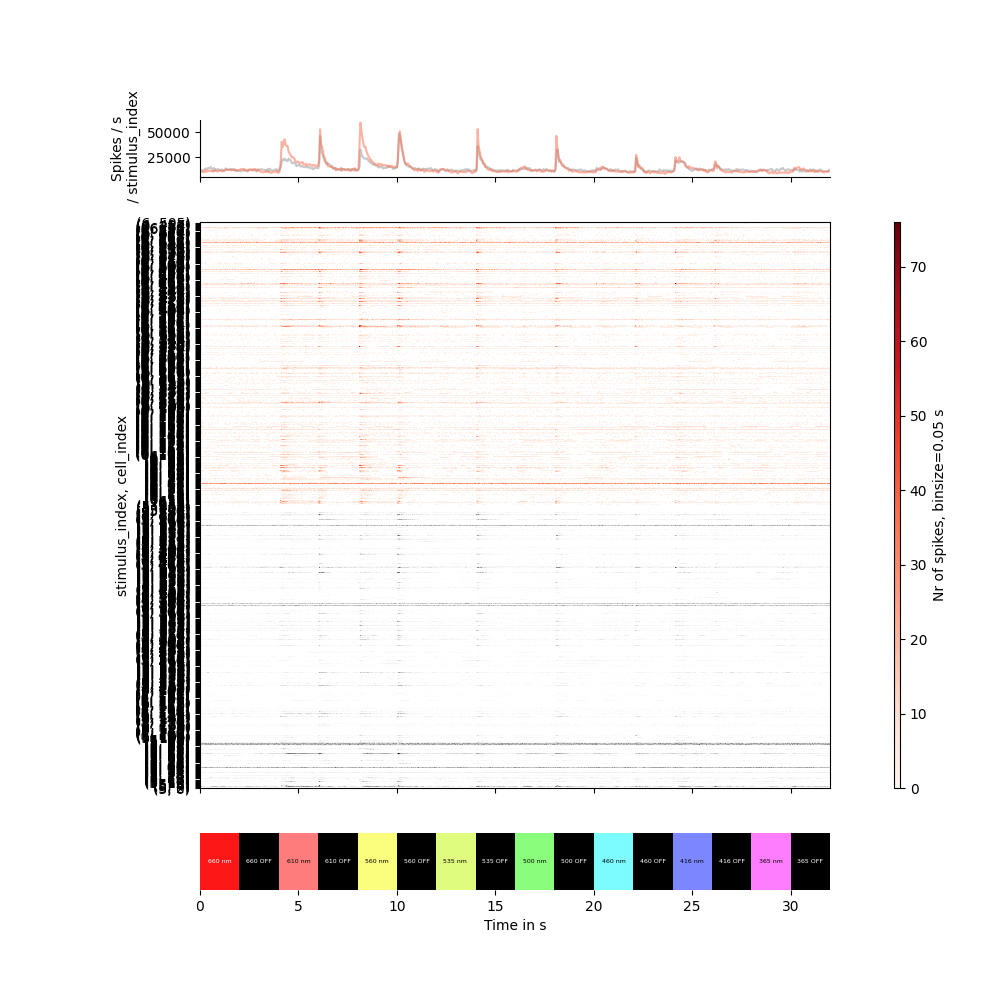

In [28]:
fig, ax = spiketrain_plots.whole_stimulus(spikes, indices=["stimulus_index", "cell_index"], cmap=["Greys", "Reds"],
                                          single_psth=False)
fig = ct.add_stimulus_to_plot(fig, [2] * 16)

# More in depth analysis
Ok, now that we covered the basics, lets go through a simple analysis pipeline. This will introduce some more functionality. We will load spikes from cells, calculate the quality of there responses and save that quality index, then we load only the cells which respond well.

In [29]:
from polarspike import quality_tests

This quality test convolves each spike with a gaussian kernel and measures the overlap across repeats. The more overlapping, the better the response. Its not the most precise quality index, but reliable and fast.

In [51]:
spikes = recording.get_spikes_triggered([{"stimulus_index": 6}])
qi = quality_tests.spiketrain_qi(spikes, max_window=2*16, max_repeat=5)

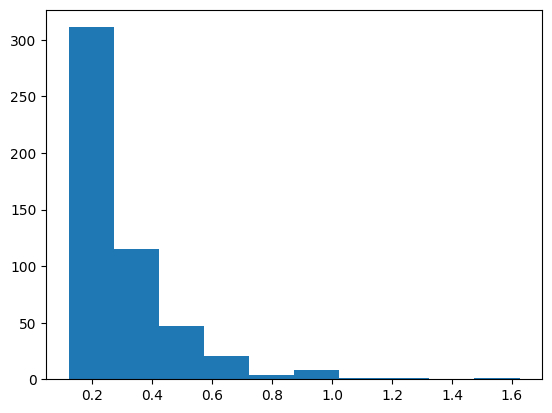

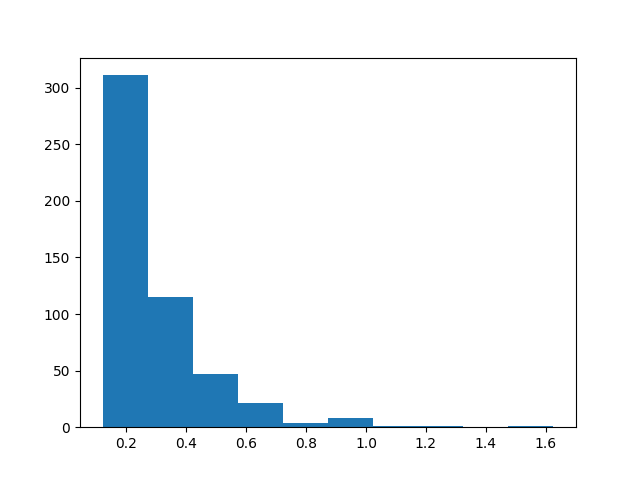

In [36]:
fig, ax = plt.subplots()
ax.hist(qi)
fig


As expected, most cells respond poor. Thats expected because spike sorting algorithms tend to generate lots of almost empty clusters. Anyways, we want to filter our cells, lets say the threshold should be 0.6
qi is a pandas dataframe, we will now expand this dataframe so that we can update our spikes_df with the quality index. We will save this updated version as a new dataframe in the recording which I will call "fff_good_cell"

In [53]:
qi["stimulus_index"] = spikes["stimulus_index"].unique()[0] # add stimulus index to qi df
qi

qi  stimulus_index
cell_index recording                                      
0          chicken_09_05_2024_p0  0.253112               6
1          chicken_09_05_2024_p0  0.939428               6
2          chicken_09_05_2024_p0  0.590960               6
3          chicken_09_05_2024_p0  0.369609               6
4          chicken_09_05_2024_p0  0.934456               6
...                                    ...             ...
579        chicken_09_05_2024_p0  0.259536               6
580        chicken_09_05_2024_p0  0.248868               6
581        chicken_09_05_2024_p0  0.465374               6
582        chicken_09_05_2024_p0  0.275943               6
583        chicken_09_05_2024_p0  0.449225               6

[509 rows x 2 columns]

In [54]:

qi = qi.reset_index().set_index(["cell_index", "stimulus_index"])

temp_df = recording.dataframes["spikes_df"].query("stimulus_index==6").set_index(["cell_index", "stimulus_index"])
temp_df.loc[qi.index, "qi"] = qi["qi"].values

# filter the dataframe for cells with qi>0.6
temp_df = temp_df.query("qi>0.6")

recording.dataframes["fff_good_cells"] = temp_df.reset_index()

In [55]:
recording.dataframes["fff_good_cells"]

cell_index  stimulus_index stimulus_name  nr_of_spikes    centres_x  \
0            1               6           fff           427     0.000000   
1            4               6           fff          1669     0.000000   
2            5               6           fff          1440     0.000000   
3            7               6           fff           338     0.000000   
4           12               6           fff          3259     0.000000   
5           47               6           fff           977   100.000000   
6           53               6           fff          1021   100.000000   
7           64               6           fff           896   100.000000   
8           66               6           fff          1031   200.000000   
9           67               6           fff          9304   196.665771   
10          78               6           fff          1894   200.000000   
11          93               6           fff          1119   200.000000   
12         104               6           fff          1722   200.000000   
13         114               6           fff            17   300.000000   
14         139               6           fff           919   301.326385   
15         146               6           fff          2995   400.000000   
16         153               6           fff          3861   400.000000   
17         210               6           fff          3341   605.838501   
18         227               6           fff          1401   602.625305   
19         308               6           fff           838   800.000000   
20         312               6           fff          1984   896.757690   
21         326               6           fff          2542   896.571960   
22         334               6           fff            41   900.000000   
23         344               6           fff          2486   896.563049   
24         360               6           fff          2099   994.557922   
25         391               6           fff           764  1096.551880   
26         394               6           fff           711  1100.000000   
27         412               6           fff          1662  1095.546509   
28         424               6           fff          1310  1102.984375   
29         425               6           fff          2993  1093.023438   
30         439               6           fff          1026  1204.426025   
31         458               6           fff          6083  1190.090942   
32         527               6           fff          3948  1407.053345   
33         564               6           fff          4600  1496.036255   

      centres_y              recording        qi  
0    300.000000  chicken_09_05_2024_p0  0.939428  
1    300.000000  chicken_09_05_2024_p0  0.934456  
2    400.001404  chicken_09_05_2024_p0  0.861226  
3    400.000000  chicken_09_05_2024_p0  0.969463  
4    604.880005  chicken_09_05_2024_p0  0.912185  
5    897.819458  chicken_09_05_2024_p0  0.971197  
6    985.269470  chicken_09_05_2024_p0  1.060463  
7   1502.696899  chicken_09_05_2024_p0  0.901012  
8      0.000000  chicken_09_05_2024_p0  0.745632  
9      0.000000  chicken_09_05_2024_p0  1.023480  
10   400.023987  chicken_09_05_2024_p0  0.741023  
11  1102.673218  chicken_09_05_2024_p0  0.686531  
12  1502.922729  chicken_09_05_2024_p0  0.670208  
13   400.000000  chicken_09_05_2024_p0  1.625581  
14  1405.709473  chicken_09_05_2024_p0  0.645389  
15     0.000670  chicken_09_05_2024_p0  0.682640  
16   400.012329  chicken_09_05_2024_p0  0.620640  
17    99.242287  chicken_09_05_2024_p0  0.668738  
18   800.000000  chicken_09_05_2024_p0  0.622667  
19  1404.113892  chicken_09_05_2024_p0  0.682694  
20   100.000000  chicken_09_05_2024_p0  0.972522  
21   497.029541  chicken_09_05_2024_p0  0.717448  
22   800.000000  chicken_09_05_2024_p0  0.604943  
23  1299.000488  chicken_09_05_2024_p0  0.643156  
24   400.000000  chicken_09_05_2024_p0  0.691646  
25     0.000000  chicken_09_05_2024_p0  0.655003  
2

So what we have done here, is take a copy of spikes_df. Filter it, so it only has the respective stimulus_index. We have changed its index, so that we can align two dataframes (spikes_df and qi). We need to align them to save the correct value of qi for each cell. Then, we created a new dataframe in the recording object. The recording object has a dictionary of dataframes called recording.dataframes. We entered a new dataframe called "fff_good_cells" into that dictionary. We can now use this dataframe for further analysis. 

In [56]:
spikes = recording.get_spikes_triggered([{"stimulus_index":6}], cell_df="fff_good_cells")

If we specifiy the "cell_df" input argument and set it, in this case, to "fff_good_cells", we load the spikes only from cells inside this dataframe. 
There is a second way of doing this:

In [57]:
spikes = recording.get_spikes_df("fff_good_cells")

This loads the whole dataframe by default

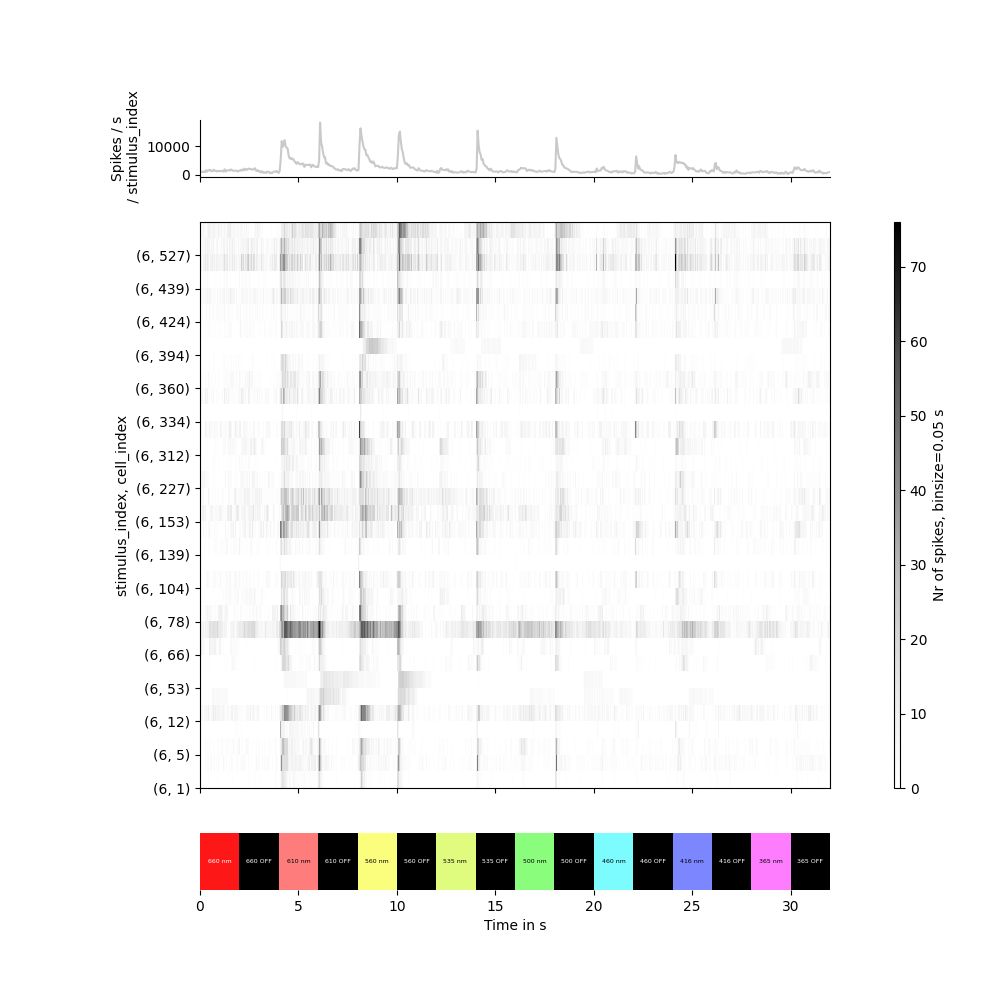

In [60]:
fig, ax = spiketrain_plots.whole_stimulus(spikes, indices=["stimulus_index", "cell_index"])
fig = ct.add_stimulus_to_plot(fig, [2]*16)